# Classify Horses and Human

https://www.kaggle.com/codeblogger/deep-learning-with-python#L-Layer-Neural-Network

Horses or Humans is a dataset of images used in learning or testing computer vision algorithms.

The set contains 500 rendered images of various species of horse in various poses in various locations. It also contains 527 rendered images of humans in various poses and locations. Emphasis has been taken to ensure diversity of humans, and to that end there are both men and women as well as Asian, Black, South Asian and Caucasians present in the training set. The validation set adds 6 different figures of different gender, race and pose to ensure breadth of data.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from tensorflow import keras
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'cv2'

### Process the data

In order to get the full dataset of images, the 'tensorflow_datasets' library has been used. With the 'load' method is possible to store in variables all the dataset indicated as parameter, splitted in training and test sets. 

In [2]:
train_ds, test_ds = tfds.load("horses_or_humans" , split=['train', 'test'], as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1027 [00:00<?, ? examples/s]

Shuffling horses_or_humans-train.tfrecord...:   0%|          | 0/1027 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/256 [00:00<?, ? examples/s]

Shuffling horses_or_humans-test.tfrecord...:   0%|          | 0/256 [00:00<?, ? examples/s]

Dataset horses_or_humans downloaded and prepared to /Users/lorenzolaino/tensorflow_datasets/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


In [3]:
train_ds = tfds.as_numpy(train_ds)
test_ds = tfds.as_numpy(test_ds)

In order to create the both image and label set it's necessary to define a method that split in two lists the images and the label. Also, since the images size are different it's necessary to resize the images using the cv2 library.

In [58]:
def create_img_label_set(data, dim) : 
    image_set = []
    label_set = []
    for img in data :
        image, label = img[0], img[1]
        res = cv2.resize(image, dsize=(dim,dim), interpolation=cv2.INTER_CUBIC)
        res = Image.resize
        image_set.append(res)
        label_set.append(label)
        
    return np.asarray(image_set), np.asarray(label_set)

With the method defined above is possible to get all the datasets necessary to continue the experiment. The images are then scaled to a fixed size of 64x64 px.

In [59]:
img_train, label_train = create_img_label_set(train_ds, 64)
img_test, label_test = create_img_label_set(test_ds, 64)

The dataset will now contains 64x64 images, like the one presented below.


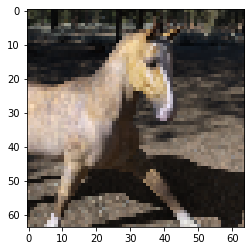

In [60]:
plt.imshow(img_train[0])
plt.show()

This define all the metadata and the information of the collected and split datasets

In [61]:
def data_summary(X_train, y_train, X_test, y_test):
    """Summarize current state of dataset"""
    print('Train images shape:', X_train.shape)
    print('Train labels shape:', y_train.shape)
    print('Test images shape:', X_test.shape)
    print('Test labels shape:', y_test.shape)

In [62]:
data_summary(img_train, label_train, img_test, label_test)

Train images shape: (1027, 64, 64, 3)
Train labels shape: (1027,)
Test images shape: (256, 64, 64, 3)
Test labels shape: (256,)


### Build the model

The following section contains the creation of the neural network. It is possible to see how the network is more complicated than the one presented in the previous experiment. In the following neural network different levels were used: 


#### Conv2D
Conv2D is a Convolution layer that defines the shape of the images passed to the model. A Convolution layer scans a source image with a filter of, in this case, 3x3 pixels, to extract features which may be important for classification. This filter is also called: Convolution Kernel. The kernel also contains weights which are tuned in the training of the model to achieve the most accurate predictions. In this model, for each 3x3 pixel region, the model computes the dot products between the image pixel values and the weights defined in the filter. The Convolution Kernel operates on a 2-dimensional space to produce an output to be processed by subsequent nodes. The method is composed by different parameter: 
- filters: is the mandatory parameter, specifies the number of filters that the convolutional layers will learn from.
- kernel-size: this parameter determines the dimensions of the kernel. It's an integer or list of 2 integers that specifies the height and width of the 2D convolution window.
- activation: this parameter specifies the name of the activation function that needs to be performed after the convolution.
- input_shape: the shape of the input images.

#### MaxPooling2D
MaxPooling2D is a pooling layer, used to reduce the dimensions of the feature maps. It reduces the number of parameters to learn and the amount of computation performed in the network. Max pooling is a pooling operation that selects the maximum element from the region of the feature map covered by the filter. Thus, the output after max-pooling layer would be a feature map containing the most prominent features of the previous feature map.
- pool_size: integer or tuple of 2 integers. It represents the window size over which to take the maximum. (2, 2) will take the max value over a 2x2 pooling window.

In [63]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), input_shape=(64,64,3)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Conv2D(32, (3, 3)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Conv2D(64, (3, 3)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2, activation='softmax'))

### Compile the model

Since the building of the neural network is completed, it's necessary to compile the model by adding some few parameters that will tell the neural network how to start the training process. The loss function used is the "sparse_categorical_crossentropy": which is a loss function used for categorizing single labels when the classes are mutually exclusive.


In [64]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='rmsprop',
              metrics=['accuracy'])

### Train the model

The model is now ready to be trained, using the "fit" method. The method defined above is fed with the training data and labeled data that correspond to the training dataset. The number of epochs is 10.

In [65]:
model.fit(img_train, label_train, validation_data=(img_test, label_test), epochs=10, batch_size=64)

Epoch 1/10
17/17 [==============================] - 3s 151ms/step - loss: 13.4430 - accuracy: 0.6115 - val_loss: 0.5115 - val_accuracy: 0.8555
Epoch 2/10
17/17 [==============================] - 2s 144ms/step - loss: 0.4146 - accuracy: 0.8403 - val_loss: 1.8737 - val_accuracy: 0.5039
Epoch 3/10
17/17 [==============================] - 2s 140ms/step - loss: 0.8574 - accuracy: 0.7663 - val_loss: 1.9782 - val_accuracy: 0.7695
Epoch 4/10
10/17 [================>.............] - ETA: 0s - loss: 0.2136 - accuracy: 0.9109

KeyboardInterrupt: 

### Evaluate the model

In this section the model is evaluated with the apposite function. The results shows that the neural network has reached 85.55% of accuracy.

In [12]:
# Model evaluation
scores = model.evaluate(img_test, label_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 82.03%


In order to have a better accuracy is possible to increase the number of epochs used in the "fit" method. The number of epochs are now 15. 
Having increased the number of epochs, the accuracy rose slightly (87.11%). The increase in epoch does not always lead to an improvement in terms of precision since it could fall into overfitting problems.

In [13]:
# Model evaluation
scores = model.evaluate(img_test, label_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 82.03%


### Make predictions

In this last section of the experiment is described how to make predictions for classify images of horses or humans that the model has never seen before.

In [14]:
def plot_image(i) :
    img = img_test[i]
    predicted = predictions[i]
    label = label_test[i]
    
    predicted_label = np.argmax(predicted)
    color = "red" if predicted_label != label else "green"
    
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predicted),
                                class_names[label]),
                                color=color)
    

In order to compute the prediction of the all test dataset collected before it is necessary the use of the "predict" method. The model predicts the whole set of tests, returning an array of values containing the probability that an image belong to the horses class or human class.

In [15]:
class_names = ["Horses", "Human"]

In [16]:
predictions = model.predict(img_test)

This section describes the tests made on the model. By the following examples it is possible the see how the model have predict the test images. Each image description describes the prediction of the model, the percentage of the prediction and, in parentheses, the exact label of the image.

148


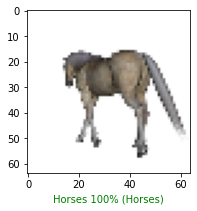

153


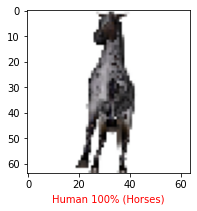

70


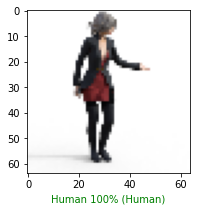

3


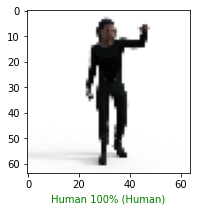

In [45]:
for i in range(0, 4) :
    
    rand = np.random.randint(0, len(img_test))
    print(rand)
    plt.figure(figsize=(6,3))
    plot_image(rand)
    plt.show()
    

In [43]:
errors = []

for i in range(0, len(img_test)) : 
    predicted = predictions[i]
    perc = 100*np.max(predicted)
    predicted_label = np.argmax(predictions[i])
    if(predicted_label != label_test[i] and perc < 98) :
        errors.append(i)

print(errors)        

[16, 35, 132, 147, 187, 246]


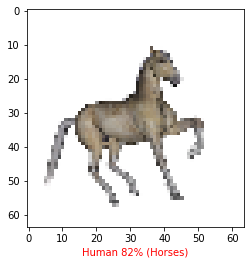

In [41]:
plot_image(246)

In [37]:
errors = []

for i in range(0, len(img_test)) : 
    predicted = predictions[i]
    perc = 100*np.max(predicted)
    if(perc <= 98) :
        errors.append(i)

print(errors)  

[2, 15, 16, 35, 113, 132, 147, 150, 165, 186, 187, 214, 245, 246]


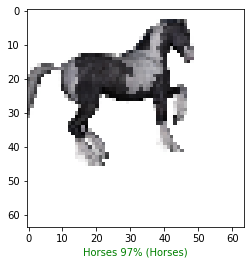

In [38]:
plot_image(245)